This notebook is based on [this Medium post](https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865) and its [associated Colab notebook](https://colab.research.google.com/drive/1bayEaw2fz_9Mhg9jFFZhrmDlQlBj1YZf?usp=sharing).

This code was then adapted for the CSCI2253: Documenting Indigenous Languages with Data Science - Final Project

It seeks to train a usable MT Model from Amis -> English. The data used in this will be linked [here](null) at a later date

This notebook was primarily adapted by Prof. Prudhummeaux and Hunter Scheppat from Boston College

Contact: scheppat@bc.edu



# 0. Preliminaries

Mount your Google Drive, which I mount in the cell below.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [ ]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [ ]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

# 1a. Segment the Data

This step segments the data into a training and test split and formats into the column alignment that the rest of this notebook uses.

It expects a csv with two columns (translation lang 1, translation lang 2)

Once you have completed this step, it does not need to be done again!

In [ ]:
import csv

counter = 1
ami_eng = []
with open('/content/drive/MyDrive/MTApplication/data/processed/shuffled_output.csv', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)  # skip the header if present; remove this line if no header
    for row in csv_reader:
        if counter % 10 == 0:
            partition = "test"
        else:
            partition = "train"
        # since there are only two columns, use row[0] for Amis and row[1] for English
        addme = [counter, counter, row[0].rstrip(), row[1], partition]
        ami_eng.append(addme)
        counter += 1

# print a sample from the list to verify output
print(ami_eng[20])

In [ ]:
import pandas as pd
# set the necessary headers
trans_df = pd.DataFrame(ami_eng)
trans_df.columns = ["row_id",	"ind", "ami",	"eng",	"split"]

pd.options.display.max_colwidth = 100

In [ ]:
trans_df.head(10)

,row_id,ind,ami,eng,split
0,1,1,saka haeminhaemin wahatira maemin tu maemin,so I drank it all Wow that is it I drank the whole thing,train
1,2,2,tayra hu i Panciaw,we still have to go to Banqiao,train
2,3,3,uni patangicen tu nu nangra a fana,they used their wisdom to barely make rules for the native peoples,train
3,4,4,anu misasakeru idengay tu,even when you are dancing,train
4,5,5,ninlingciyecen,age group,train
5,6,6,anu cima namu ku mangalayay a malasakakaay i ka malukuli nu tamdamdaw,and whoever wants to be first must be slave of all,train
6,7,7,suwal sa ciira Patiku kaku a minukay tuya nanu kaitiraan aku a luma saan ciira patiku satu ciira...,then it says I will return to the house I left when it arrives it finds the house unoccupied swe...,train
7,8,8,kaered tu,rope,train
8,9,9,anu tangasa tu i Sibuluay u muhtingaytu,if you reach the bottom of the moon your eyebrows will be black,train
9,10,10,araw sa ya Kawasay a uner kemanay tu tamdaw,you know the man eating python,test


In [ ]:
# save the segmented data
trans_df.to_csv('/content/drive/MyDrive/local_mt/fine_tuned_improved/amis-english-segmented.csv')

# 1b. Loading the segmented data

This step loads and tokenizes the prior segmented data


In [ ]:
import pandas as pd

# load the DataFrame from the CSV file
trans_df = pd.read_csv('/content/drive/MyDrive/MTApplication/data/processed/amis-english-segmented.csv')
pd.options.display.max_colwidth = 100

trans_df = trans_df.applymap(lambda x: x.lower() if type(x) == str else x)

In [ ]:
trans_df.tail(10)

,Unnamed: 0,row_id,ind,ami,eng,split
78156,78156,78157,78157,latek caayay ka suelin kaurira tu hatiniay mataleday,it is not always reliable but it is usually very flexible,train
78157,78157,78158,78158,papina ku misangaan tu emu,there are a few people who make homemade sweet rice cakes,train
78158,78158,78159,78159,away maaraw ku hemay satu sa u kunga,i do not see any rice in the main course and the whole pot is filled with groundnuts,train
78159,78159,78160,78160,o pangcah tayan paywan punung lukay piwma tau saysiya taruku cu kafalan sakiraya secik atu saw,the amis atayal paiwan bunun rukai penan yami saisiat taroko tsou kavalan sakia sedek and thao,test
78160,78160,78161,78161,pacauf sa kuya kapah madu^duaytu aku a ma^min kunini a limuut o maanhu ku caay ka^deng aku saw h...,all these i have kept the young man said what do i still lack,train
78161,78161,78162,78162,mahaen ku niyam,we do,train
78162,78162,78163,78163,ya kilang i tangsul sanay misalumaʼan ita,are you going to build a house out of the trees you took,train
78163,78163,78164,78164,hay ya licay aku,yes about what i am asking is,train
78164,78164,78165,78165,hanhan mihaen matatudung tu ku kakahad rira san,that is the way to do it if it is the right width,train
78165,78165,78166,78166,tu,grounded,train


In [ ]:
trans_df.isnull().sum()

Unnamed: 0    0
row_id        0
ind           0
ami           0
eng           0
split         0
dtype: int64

In [ ]:
trans_df.split.value_counts()

split
train    70386
test      7820
Name: count, dtype: int64

In [ ]:
df_train = trans_df[trans_df['split'] == 'train'].copy()
# this dev df will be null, since we decided not to use that to get more training data
df_dev = trans_df[trans_df['split'] == 'dev'].copy()
df_test = trans_df[trans_df['split'] == 'test'].copy()

# 2. How well does the data fit into a NLLB tokenizer?

In [ ]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [ ]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [ ]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [ ]:
smpl = df_train

smpl['eng_toks'] = smpl.eng.apply(tokenizer.tokenize)
smpl['ami_toks'] = smpl.ami.apply(tokenizer.tokenize)

smpl['eng_words'] = smpl.eng.apply(word_tokenize)
smpl['ami_words'] = smpl.ami.apply(word_tokenize)

In [ ]:
smpl.sample(5)[['ami', 'ami_words', 'ami_toks', 'eng', 'eng_words', 'eng_toks']]

,ami,ami_words,ami_toks,eng,eng_words,eng_toks
63687,miiya tu i,"[miiya, tu, i]","[▁mi, iya, ▁tu, ▁i]",just do it just do it,"[just, do, it, just, do, it]","[▁just, ▁do, ▁it, ▁just, ▁do, ▁it]"
59363,pasasuʼusuʼuten amin,"[pasasuʼusuʼuten, amin]","[▁pas, asu, ʼ, usu, ʼ, uten, ▁amin]",they are all tied to each other,"[they, are, all, tied, to, each, other]","[▁they, ▁are, ▁all, ▁tied, ▁to, ▁each, ▁other]"
36521,ca ka pateras kita anu cu ku miharatengan ita haw,"[ca, ka, pateras, kita, anu, cu, ku, miharatengan, ita, haw]","[▁ca, ▁ka, ▁pat, eras, ▁kita, ▁anu, ▁cu, ▁ku, ▁mi, har, at, engan, ▁ita, ▁haw]",we do not go around looking for unsuitable people,"[we, do, not, go, around, looking, for, unsuitable, people]","[▁we, ▁do, ▁not, ▁go, ▁around, ▁looking, ▁for, ▁un, su, itable, ▁people]"
63474,tuluay ku rumiʼad,"[tuluay, ku, rumiʼad]","[▁tulu, ay, ▁ku, ▁r, umi, ʼ, ad]",it will be three days,"[it, will, be, three, days]","[▁it, ▁will, ▁be, ▁three, ▁days]"
34353,maharek tu kita mireper ira ku mialaay ma haw,"[maharek, tu, kita, mireper, ira, ku, mialaay, ma, haw]","[▁mahar, ek, ▁tu, ▁kita, ▁mire, per, ▁ira, ▁ku, ▁miala, ay, ▁ma, ▁haw]",we are catching good wine anyone want to buy it,"[we, are, catching, good, wine, anyone, want, to, buy, it]","[▁we, ▁are, ▁cat, ching, ▁good, ▁wine, ▁anyone, ▁want, ▁to, ▁buy, ▁it]"


In [ ]:
stats = smpl[['eng_toks', 'ami_toks', 'eng_words', 'ami_words']].applymap(len).describe()
stats

,eng_toks,ami_toks,eng_words,ami_words
count,70386.000000,70386.000000,70386.000000,70386.000000
mean,8.561546,11.389808,7.436806,6.877618
std,7.204049,11.166638,6.300096,6.863882
min,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,3.000000,3.000000
50%,7.000000,9.000000,6.000000,5.000000
75%,11.000000,13.000000,9.000000,8.000000
max,73.000000,97.000000,63.000000,62.000000


The tokenizer sizes were a little small here, ideally they should be around 2. Perhaps there is an easy way to address this?

In [ ]:
print(stats.eng_toks['mean'] / stats.eng_words['mean'])
print(stats.ami_toks['mean'] / stats.ami_words['mean'])

1.1512397625738613
1.6560687313050517


In [ ]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


One more check: how often does the <unk> token happen in the tokenizer output for Amis? If this is too often, we need to fix it somehow

In [ ]:
texts_with_unk = [text for text in tqdm(trans_df.ami) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/78206 [00:00<?, ?it/s]

1


In [ ]:
### If you get anything larger than 5 above, you can run this code to see what the unknown tokens are

import random
s = random.sample(texts_with_unk, 1)
print(s)

['saka u ukuling u nanuculing nu ripㄧn sanay kiraan u ukuling']


Apparently, most of the texts with 3634 unknown tokens just have some punctuation unfamiliar to the NLLB tokenizer.

This is because the NLLB model was pretrained on normalized texts. If we reproduce the normalization, most of the problems would be fixed.

In [ ]:
# I didn't actually run this code because we didn't have any unknown tokens after all the normalization.

# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/1 [00:00<?, ?it/s]

1


Indeed, after normalizing texts, none of them contain unknown tokens. We will use this as one more piece of evidence that we don't have to update the tokenizer vocabulary to use it with Amis.

# 3. Expanding the Vocab - not currently working!

This section attempts to expand the tokenizer using words from the amis wiki

It is not currently working

In [ ]:
import pandas as pd
import re
from tqdm.auto import tqdm
from collections import Counter

# Load CSV file
ami_wiki = pd.read_csv('/content/drive/My Drive/local_mt/fine_tuned_improved/data/vocab/amis-wiki-cleaned.csv')

# Count characters
print(sum(len(t) for t in ami_wiki['text']))
print(sum(len(t) for t in trans_df.ami))


Put all the texts together



In [ ]:
from collections import Counter
import pandas as pd
from tqdm import tqdm

# Example preprocessing function
def preproc(text):
    # Assuming some normalization like lowercasing and stripping spaces
    return text.lower().strip()

# Convert both series to lists and concatenate them
all_texts = ami_wiki['text'].tolist() + df_train.ami.dropna().tolist()

# Normalize the text
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]

# Create a counter for all characters in the normalized texts
chars_cnt = Counter(c for t in all_text_normalized for c in t)

# Generate a string of required characters
required_chars = ''.join([k for k, v in chars_cnt.most_common() if v >= 10 and k not in ' '])

# Write all texts to a file
with open('myv_texts_plain.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(all_texts))


100%|██████████| 64079/64079 [00:03<00:00, 21068.47it/s]


Add new tokens to the existing tokenizer

In [ ]:
import sentencepiece as spm

all_texts_file = 'myv_texts_plain.txt'
SPM_PREFIX = 'spm_amis_16k'

with open(all_texts_file, 'w') as f:
  print("hello")
  for i, text in enumerate(all_texts):
      print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**14,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

In [ ]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = 'spm_nllb_amis_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Add to the model

In [ ]:
from transformers import AutoModelForSeq2SeqLM
model_name = 'facebook/nllb-200-distilled-600M'

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268915
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12710

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 268926
12721


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 268926. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
100%|██████████| 12721/12721 [00:06<00:00, 1942.21it/s]


Fix the old tokenizer

In [ ]:
n_new_tokens = len(tokenizer) - len(tokenizer_old)
print(n_new_tokens)

12722


In [ ]:
def fix_tokenizer(tokenizer, new_lang='ami_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fix_tokenizer(tokenizer)

In [ ]:
print(tokenizer.convert_ids_to_tokens([268557, 268558, 268559])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['ami_Latn', 'ami_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['enganna', 'parasur', 'sapipasadakan']
[3, 268925, 268926]


In [ ]:
added_token_id = tokenizer.convert_tokens_to_ids('tyv_Cyrl')
similar_lang_old_id = tokenizer_old.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_old_id)

3 256095


In [ ]:
moved_tokens = list(tokenizer_old.lang_code_to_id) + ['<mask>']

In [ ]:
model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('tyv_Cyrl')] = model.model.shared.weight.data[tokenizer_old.convert_tokens_to_ids('kir_Cyrl')]

In [ ]:
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))

12722


In [ ]:
for t in tqdm(added_vocab):
    if t == 'ami_Cyrl':
        continue
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        print(f'empty token "{t}"/{tokenizer.convert_tokens_to_ids(t)}')
        tt = [tokenizer_old.unk_token_id]
    model.model.shared.weight.data[tokenizer.convert_tokens_to_ids(t)] = model.model.shared.weight.data[tt].mean(0)

 19%|█▉        | 2396/12722 [00:00<00:03, 3229.40it/s]

empty token ""/268722


 65%|██████▍   | 8234/12722 [00:02<00:01, 3328.28it/s]

empty token " "/268721


100%|██████████| 12722/12722 [00:03<00:00, 3317.37it/s]


# 4. Adding a new language tag to the tokenizer and model

This step adds the new amis tag to the model

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [ ]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def fix_tokenizer(tokenizer, new_lang='ami_Latn'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fix_tokenizer(tokenizer)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zulLatn', 'ami_Latn', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'ami_Latn', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'ami_Latn', '<mask>']
[256202, 256203, 256204]


In [ ]:
added_token_id = tokenizer.convert_tokens_to_ids('ami_Latn')
similar_lang_id = tokenizer.convert_tokens_to_ids('tgl_Latn')
print(added_token_id, similar_lang_id)

256203 256174


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [ ]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

In [ ]:
# dont execute unless resuming training
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM
model_load_name = '/content/drive/MyDrive/MTApplication/models/new-nllb-ami-eng-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# 5. Preparing the training loop

In [ ]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
model.cuda();

In [ ]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
training_steps = 4000
losses = []


In [ ]:
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=100)

In [ ]:
import random
LANGS = [('eng', 'eng_Latn'), ('ami', 'ami_Latn')]

def get_batch_pairs(batch_size, data=df_train):
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item['eng'])
        yy.append(item['ami'])
    return xx, yy, 'eng_Latn', 'ami_Latn'

print(get_batch_pairs(1))


(['i have worn clothes made of tree bark'], ['u sirikuʼay tu hatiniay a tulak nu kilang'], 'eng_Latn', 'ami_Latn')


In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/MTApplication/models/new-nllb-ami-eng-v1'

This check makes sure we are not training our model the wrong way!

In [ ]:
import random

def pre_training_check(data, num_samples=5):
    samples = data.sample(num_samples, random_state=42)
    for idx, row in samples.iterrows():
        amis_text = row['ami']
        english_text = row['eng']
        print(f"Sample {idx}: Amis -> English")
        print("Amis: ", amis_text)
        print("English: ", english_text)
        print("Tokenized Amis: ", tokenizer.tokenize(amis_text, lang='ami_Latn'))
        print("Tokenized English: ", tokenizer.tokenize(english_text, lang='eng_Latn'))
        print("-" * 80)

# Call this function before starting the training loop
pre_training_check(df_train)


Keyword arguments {'lang': 'ami_Latn'} not recognized.
Keyword arguments {'lang': 'eng_Latn'} not recognized.
Keyword arguments {'lang': 'ami_Latn'} not recognized.
Keyword arguments {'lang': 'eng_Latn'} not recognized.
Keyword arguments {'lang': 'ami_Latn'} not recognized.
Keyword arguments {'lang': 'eng_Latn'} not recognized.
Keyword arguments {'lang': 'ami_Latn'} not recognized.
Keyword arguments {'lang': 'eng_Latn'} not recognized.
Keyword arguments {'lang': 'ami_Latn'} not recognized.
Keyword arguments {'lang': 'eng_Latn'} not recognized.


Sample 778: Amis -> English
Amis:  pakuyuc ku urip
English:  living in poverty
Tokenized Amis:  ['▁paku', 'y', 'uc', '▁ku', '▁urip']
Tokenized English:  ['▁living', '▁in', '▁pov', 'erty']
--------------------------------------------------------------------------------
Sample 48995: Amis -> English
Amis:  o rumasatu maaraw nangra ku nika tumireng nuya niadahan nangra a tamdaw i tatihi nangra saka awaaytu ku sapacawicawi nangra a pasuwal
English:  but since they could see the man who had been healed standing there with them there was nothing they could say
Tokenized Amis:  ['▁o', '▁rum', 'as', 'atu', '▁ma', 'araw', '▁nang', 'ra', '▁ku', '▁nika', '▁tum', 'ir', 'eng', '▁nu', 'ya', '▁ni', 'ada', 'han', '▁nang', 'ra', '▁a', '▁tam', 'daw', '▁i', '▁tati', 'hi', '▁nang', 'ra', '▁saka', '▁awa', 'ay', 'tu', '▁ku', '▁sapa', 'ca', 'wi', 'ca', 'wi', '▁nang', 'ra', '▁a', '▁pasu', 'wal']
Tokenized English:  ['▁but', '▁since', '▁they', '▁could', '▁see', '▁the', '▁man', '▁who', '▁had', '▁been', '▁hea', 

# 6. The training loop

In [ ]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        # -100 is a magic value ignored in the loss function
        # because we don't want the model to learn to predict padding ids
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:  # usually, it is out-of-memory
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        # each 1000 steps, I report average loss at these steps
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/4000 [00:00<?, ?it/s]

0 0.2896847724914551
1000 0.2875419929102063
2000 0.2891490706950426


KeyboardInterrupt: 

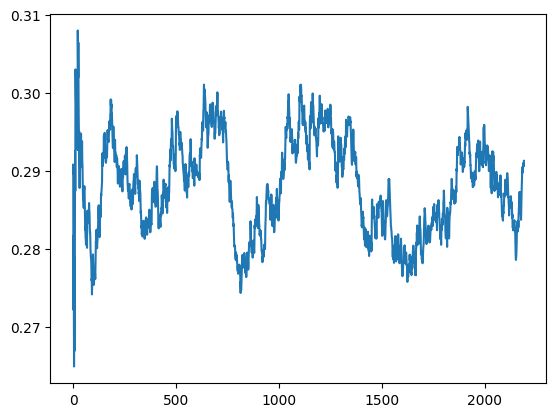

In [ ]:
pd.Series(losses).ewm(100).mean().plot();

# 7. Evaluating the model

This section evaluates the model using bleu and chrf+

In [ ]:
!pip install unbabel-comet
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 47.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
# Evaluate test data on the model using comet(maybe), bleu, and word error rate
import pandas as pd
import torch
import sacrebleu
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, Dataset

# Load the trained model and tokenizer
model_path = '/content/drive/MyDrive/MTApplication/models/new-nllb-ami-eng-v1'

tokenizer = NllbTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Evaluation Metrics:


,Metric,Score
0,BLEU,15.586695
1,chrF++,40.108371
2,WER,0.851819


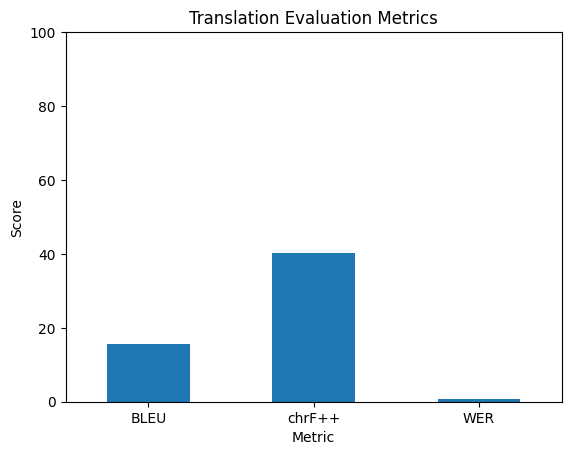


10 Random Predictions and Actual Translations:


,Predicted Translation,Actual Translation
7037,ira hu ku sasangaʼan ira tu,kararuman nu niyam haw i
5114,telang,maulaway
5913,iraay tu ku nisuritan nu misu,tadangaʼay ku demak isu mansa
39,aca,edeng
299,patalaluma,paluma
2606,u mamu niyam,ya ama nu mita kiyami
5048,mikihatiya tu finawlan talacuwacuwa,kumuden han a misausi atu i cuawcuwaay ku aru
4205,vaki adihay ku kakituhen isu,vaki adihay ku kungku nu misu haw
2408,mipalamalay,rafraf
5770,milecapu,kasaupuan


In [ ]:
import pandas as pd
import sacrebleu
from jiwer import wer
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, Dataset

class TranslationDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")
        return inputs

model.eval()

# Load your test set DataFrame
texts = df_test['eng'].tolist()
actual_translations = df_test['ami'].tolist()

dataset = TranslationDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=10)

predicted_translations = []

for batch in dataloader:
    input_ids = batch['input_ids'].squeeze(1).cuda()
    attention_mask = batch['attention_mask'].squeeze(1).cuda()

    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

    preds = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    predicted_translations.extend(preds)

# Calculate Evaluation Metrics
bleu_score = sacrebleu.corpus_bleu(predicted_translations, [actual_translations]).score
chrf_score = sacrebleu.corpus_chrf(predicted_translations, [actual_translations]).score
wer_score = wer(actual_translations, predicted_translations)

# Prepare metrics display
metrics = pd.DataFrame({
    "Metric": ["BLEU", "chrF++", "WER"],
    "Score": [bleu_score, chrf_score, wer_score]
})

# Display Metrics Table
print("Evaluation Metrics:")
display(metrics)

# Plot Metrics
metrics.set_index("Metric").plot(kind='bar', legend=None)
plt.title('Translation Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.show()

# Display 10 random predictions
random_samples = pd.DataFrame({
    "Predicted Translation": predicted_translations,
    "Actual Translation": actual_translations
}).sample(10, random_state=1)
print("\n10 Random Predictions and Actual Translations:")
display(random_samples)


# 8. Publishing!

Lets make it offical

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [ ]:
upload_repo = "hunterschep/nllb-eng-ami-final"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hunterschep/nllb-eng-ami-final/commit/e6e795427bcd275720af2710ac2becfd6bbeb69e', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='e6e795427bcd275720af2710ac2becfd6bbeb69e', pr_url=None, pr_revision=None, pr_num=None)